# Processamento de dados

Importando as bibliotecas necessárias para a criação do ambiente

In [ ]:
# Data Analysis
import pandas as pd
import numpy as np

# Data Visualization
from matplotlib import pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

# Warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

train_id = pd.read_csv('/content/drive/MyDrive/p2_miceli/train_identity.csv')
train_transaction = pd.read_csv('/content/drive/MyDrive/p2_miceli/train_transaction.csv')
test_id = pd.read_csv('/content/drive/MyDrive/p2_miceli/test_identity.csv')
test_transaction = pd.read_csv('/content/drive/MyDrive/p2_miceli/test_transaction.csv')

Diminuímos o tamanho das tabelas

In [ ]:
# Helper function
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [ ]:
print(train_transaction.shape)
train_transaction = reduce_mem_usage(train_transaction)
train_transaction.head()

(590540, 394)
Memory usage of dataframe is 1775.15 MB
Memory usage after optimization is: 487.16 MB
Decreased by 72.6%


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
print(train_id.shape)
train_identity = reduce_mem_usage(train_id)
train_id.head()

(144233, 41)
Memory usage of dataframe is 45.12 MB
Memory usage after optimization is: 10.00 MB
Decreased by 77.8%


,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [ ]:
train = pd.merge(train_transaction, train_id, how='left')
print(train.shape)
len_train = len(train)
del train_transaction, train_id
train.head()

(590540, 434)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [ ]:

print(test_transaction.shape)
test_transaction = reduce_mem_usage(test_transaction)




(506691, 393)
Memory usage of dataframe is 1519.24 MB
Memory usage after optimization is: 425.24 MB
Decreased by 72.0%


In [ ]:
print(test_id.shape)
test_id = reduce_mem_usage(test_id)


(141907, 41)
Memory usage of dataframe is 44.39 MB
Memory usage after optimization is: 9.84 MB
Decreased by 77.8%


In [ ]:
test = pd.merge(test_transaction, test_id, how='left')
test.columns = train.drop('isFraud', axis=1).columns
print(test.shape)
del test_transaction, test_id
test.head()

(506691, 433)


,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663549,18403224,31.953125,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.000000,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.000000,W,4476,574.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,285.000000,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.937500,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Creating a submission file
submission = pd.DataFrame({'TransactionID':test.TransactionID})
print(submission.shape)

(506691, 1)


In [ ]:
# Duplicates check in train data
train.duplicated().sum()

0

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1f77f37e80>,
      dtype=object)

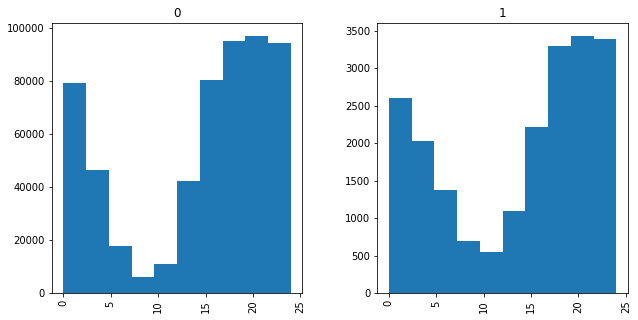

In [ ]:
test['TransactionHora'] = test['TransactionDT'].apply(lambda x: x%(60*60*24)/60/60)
train['TransactionHora'] = train['TransactionDT'].apply(lambda x: x%(60*60*24)/60/60)
train['TransactionHora'].hist(by=train['isFraud'], figsize=(10,5))

In [ ]:
# Missing values check
combined_df = pd.concat([train.drop(columns=['isFraud', 'TransactionID']), test.drop(columns='TransactionID')])
print(combined_df.shape)

# Dependent variable
y = train['isFraud']
print(y.shape)

# Dropping columns with more than 20% missing values 
mv = combined_df.isnull().sum()/len(combined_df)
combined_mv_df = combined_df.drop(columns=mv[mv>0.2].index)
del combined_df, train, test
print(combined_mv_df.shape)

(1097231, 433)
(590540,)
(1097231, 181)


In [ ]:
# Filtering numerical data
num_mv_df = combined_mv_df.select_dtypes(include=np.number)
print(num_mv_df.shape)

# Filtering categorical data
cat_mv_df = combined_mv_df.select_dtypes(exclude=np.number)
print(cat_mv_df.shape)
del combined_mv_df

# Filling missing values by median for numerical columns 
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
num_df = pd.DataFrame(imp_median.fit_transform(num_mv_df), columns=num_mv_df.columns)
del num_mv_df
print(num_df.shape)

# Filling missing values by most frequent value for categorical columns
imp_max = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
cat_df = pd.DataFrame(imp_max.fit_transform(cat_mv_df), columns=cat_mv_df.columns)
del cat_mv_df
print(cat_df.shape)

# Concatinating numerical and categorical data
combined_df_cleaned = pd.concat([num_df, cat_df], axis=1)
del num_df, cat_df

# Verifying missing values
print(f'Total missing values: {combined_df_cleaned.isnull().sum().sum()}')
print(combined_df_cleaned.shape)
combined_df_cleaned.head()

(1097231, 177)
(1097231, 4)
(1097231, 177)
(1097231, 4)
Total missing values: 0
(1097231, 181)


,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,C1,C2,...,V317,V318,V319,V320,V321,TransactionHora,ProductCD,card4,card6,P_emaildomain
0,86400.0,68.5,13926.0,361.0,150.0,142.0,315.0,87.0,1.0,1.0,...,117.0,0.0,0.0,0.0,0.0,0.000000,W,discover,credit,gmail.com
1,86401.0,29.0,2755.0,404.0,150.0,102.0,325.0,87.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.000278,W,mastercard,credit,gmail.com
2,86469.0,59.0,4663.0,490.0,150.0,166.0,330.0,87.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.019167,W,visa,debit,outlook.com
3,86499.0,50.0,18132.0,567.0,150.0,117.0,476.0,87.0,2.0,5.0,...,1404.0,790.0,0.0,0.0,0.0,0.027500,W,mastercard,debit,yahoo.com
4,86506.0,50.0,4497.0,514.0,150.0,102.0,420.0,87.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.029444,H,mastercard,credit,gmail.com


In [ ]:
# One-hot encoding
pd.pandas.set_option('display.max_columns', None)
combined_df_encoded = pd.get_dummies(combined_df_cleaned, drop_first=True)
print(combined_df_encoded.shape)
del combined_df_cleaned
combined_df_encoded.head()

(1097231, 246)


,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D10,D15,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,TransactionHora,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W,card4_discover,card4_mastercard,card4_visa,card6_credit,card6_debit,card6_debit or credit,P_emaildomain_anonymous.com,P_emaildomain_aol.com,P_emaildomain_att.net,P_emaildomain_bellsouth.net,P_emaildomain_cableone.net,P_emaildomain_centurylink.net,P_emaildomain_cfl.rr.com,P_emaildomain_charter.net,P_emaildomain_comcast.net,P_emaildomain_cox.net,P_emaildomain_earthlink.net,P_emaildomain_embarqmail.com,P_emaildomain_frontier.com,P_emaildomain_frontiernet.net,P_emaildomain_gmail,P_emaildomain_gmail.com,P_emaildomain_gmx.de,P_emaildomain_hotmail.co.uk,P_emaildomain_hotmail.com,P_emaildomain_hotmail.de,P_emaildomain_hotmail.es,P_emaildomain_hotmail.fr,P_emaildomain_icloud.com,P_emaildomain_juno.com,P_emaildomain_live.com,P_emaildomain_live.com.mx,P_emaildomain_live.fr,P_emaildomain_mac.com,P_emaildomain_mail.com,P_emaildomain_me.com,P_emaildomain_msn.com,P_emaildomain_netzero.com,P_emaildomain_netzero.net,P_emaildomain_optonline.net,P_emaildomain_outlook.com,P_emaildomain_outlook.es,P_emaildomain_prodigy.net.mx,P_emaildomain_protonmail.com,P_emaildomain_ptd.net,P_emaildomain_q.com,P_emaildomain_roadrunner.com,P_emaildomain_rocketmail.com,P_emaildomain_sbcglobal.net,P_emaildomain_sc.rr.com,P_emaildomain_scranton.edu,P_emaildomain_servicios-ta.com,P_emaildomain_suddenlink.net,P_emaildomain_twc.com,P_emaildomain_verizon.net,P_emaildomain_web.de,P_emaildomain_windstream.net,P_emaildomain_yahoo.co.jp,P_emaildomain_yahoo.co.uk,P_emaildomain_yahoo.com,P_emaildomain_yahoo.com.mx,P_emaildomain_yahoo.de,P_emaildomain_yahoo.es,P_emaildomain_yahoo.fr,P_emaildomain_ymail.com
0,86400.0,68.5,13926.0,361.0,150.0,142.0,315.0,87.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,13.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.000000,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,86401.0,29.0,2755.0,404.0,150.0,102.0,325.0,87.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,

In [ ]:
# Separating train and test data
X = combined_df_encoded.iloc[:len_train]
print(X.shape)
test = combined_df_encoded.iloc[len_train:]
print(test.shape)
del combined_df_encoded

(590540, 246)
(506691, 246)


In [ ]:
# Time-based train validation splitting with 20% data in validation set
train = pd.concat([X, y], axis=1)
train.sort_values('TransactionDT', inplace=True)
X = train.drop(['isFraud'], axis=1)
y = train['isFraud']
splitting_index = int(0.8*len(X))
X_train = X.iloc[:splitting_index].values
X_val = X.iloc[splitting_index:].values
y_train = y.iloc[:splitting_index].values
y_val = y.iloc[splitting_index:].values
test = test.values
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)
del y, train

(472432, 246) (118108, 246) (472432,) (118108,)


In [ ]:
# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
test_scaled = scaler.transform(test)
del X_train, X_val, test

# Class imbalance check
pd.value_counts(y_train)

0    455833
1     16599
dtype: int64

Eu tentei o PCA para reduzir a dimensão, mas resultou em um desempenho relativamente ruim, portanto, usaremos apenas essas dimensões.
Após o ajuste do hiperparâmetro, os seguintes parâmetros são selecionados.

In [ ]:
# Applying SMOTE to deal with the class imbalance by oversampling
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)
print(X_train_smote.shape, y_train_smote.shape)
del X_train_scaled, y_train
pd.value_counts(y_train_smote)


(911666, 246) (911666,)


0    455833
1    455833
dtype: int64

In [ ]:
# Random Forest Classifier
rfc = RandomForestClassifier(criterion='entropy', max_features='sqrt', max_samples=0.5, min_samples_split=80)
rfc.fit(X_train_smote, y_train_smote)
y_predproba = rfc.predict_proba(X_val_scaled)
print(f'Validation AUC={roc_auc_score(y_val, y_predproba[:, 1])}')

Validation AUC=0.8870116289123247


A vantagem do Radom forest é que ele é mais explicavel e você consegue entender o que ta acontecendo 

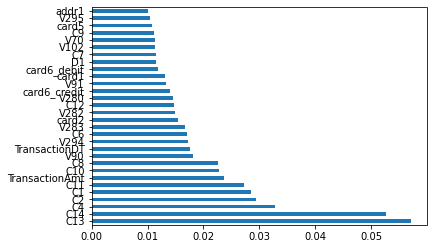

In [ ]:
# Feature importances
pd.Series(rfc.feature_importances_, index=X.columns).nlargest(30).plot(kind='barh')
plt.show()

In [ ]:
# Predicting for the test data 
predictions = rfc.predict_proba(test_scaled)
submission['isFraud'] = predictions[:, 1]
print(submission.shape)
submission.head()

(506691, 2)


,TransactionID,isFraud
0,3663549,0.048811
1,3663550,0.032669
2,3663551,0.166405
3,3663552,0.050104
4,3663553,0.178084


In [ ]:
# Submitting the predictions
submission.to_csv('submission.csv', index=False)
print('Submission is successful!')

Submission is successful!


In [ ]:

from sklearn.linear_model import LogisticRegression 

clf = LogisticRegression(penalty='l2', C=0.1)
clf.fit(X_train_smote, y_train_smote)
y_pred = clf.predict(X_val_scaled)

In [ ]:
y_val

array([1, 0, 0, ..., 0, 0, 0], dtype=int8)

In [ ]:
y_pred

array([1, 0, 1, ..., 0, 1, 1], dtype=int8)

In [ ]:
from sklearn import metrics   

print("Accuracy", metrics.accuracy_score(y_val, y_pred))


Accuracy 0.674467436583466
